## Import dataset

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tmq01-visits-to-and-from-ireland/resource/d018a88d-6944-4728-aa62-cd05074ffa5e

df1 = pd.read_csv("TMQ01-Visits-to-and-from-Ireland.csv")
df2 = pd.read_csv("TMQ03-Expenditure-of-Visitors-to-and-from-Ireland.csv")
df3 = pd.read_csv("TMA04-Visits-to-and-from-Ireland.csv")
df4 = pd.read_csv("TMA05-Visits-to-and-from-Ireland.csv")

### Dataset 1 Exploration and Cleaning

In [6]:
# Explore df1 dataset
# TMQ01-Visits-to-and-from-Ireland dataset contains 8 columns and 960 rows 
# (24 years in Quarters = 96 rows), 96 rows by 2 inbound/outbound = 192 rows, 192 rows by 5 regions = 960 rows
# Columns: ROUTE, Route of Travel, TLIST(Q1), Quarter,STATISTIC, Statistic Label, UNIT, VALUE
df1.shape

(960, 8)

In [7]:
# Display column names in dataset
print(df1.columns)

Index(['ROUTE', 'Route of Travel', 'TLIST(Q1)', 'Quarter', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


In [8]:
df1['Route of Travel'].value_counts()
df1['ROUTE'].value_counts()
df1['Statistic Label'].value_counts()
df1['TLIST(Q1)'].value_counts()
df1['UNIT'].value_counts()
df1['VALUE'].value_counts(bins=5)

Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

ROUTE
0    192
1    192
2    192
3    192
4    192
Name: count, dtype: int64

Statistic Label
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

TLIST(Q1)
19851    10
19852    10
20023    10
20022    10
20021    10
         ..
19922    10
19921    10
19914    10
19913    10
20084    10
Name: count, Length: 96, dtype: int64

UNIT
Thousand    960
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

In [9]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
df1_tourism = df1.drop(columns=['UNIT', 'ROUTE', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
df1_tourism.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
df1_tourism["Year"] = df1_tourism["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
df1_tourism["Quarter"] = df1_tourism["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Inbound/Outbound
df1_tourism.rename(columns={"Statistic Label": "Inbound/Outbound"}, inplace=True)

# Rename Column for Travellers x 1,000
df1_tourism.rename(columns={"VALUE": "Travellers (x 10^3)"}, inplace=True)

df1_tourism.shape

(960, 5)

In [10]:
# Display column names in edited dataset
print(df1_tourism.columns)

Index(['Route of Travel', 'Year', 'Quarter', 'Inbound/Outbound',
       'Travellers (x 10^3)'],
      dtype='object')


In [11]:
# Select cross channel travel by both sea and air for each quarter and year from the dataset
cross_channel_df = df1_tourism[df1_tourism.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True]
#pd.set_option('display.max_rows', cross_channel_df.shape[0]+1)
cross_channel_df.shape

(384, 5)

In [12]:
# Combine Air and Sea cross channel travel into Cross channel travel dataframe
combined_cross_channel = cross_channel_df.groupby(['Year', 'Quarter', 'Inbound/Outbound'], as_index=False).sum()
combined_cross_channel['Route of Travel'] = 'Cross Channel'
combined_cross_channel.shape

(192, 5)

In [13]:
# Remove Air and Sea Cross Channel travel from original dataset
df1_tourism = df1_tourism.drop(df1_tourism[df1_tourism.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True].index)

In [14]:
# Concatenate original dataset with new Cross Channel travel dataset
df1_tourism = pd.concat([df1_tourism, combined_cross_channel], axis=0, ignore_index=True)
#pd.set_option('display.max_rows', df1_tourism.shape[0]+1)
# df1_tourism

In [15]:
# Change order of routes to "All Routes", "Cross Channel", "Continental Europe", and "Transatlantic" to be consistent with the original dataset.
concatenated_df1_tourism = pd.concat([df1_tourism[df1_tourism['Route of Travel'] == 'All Routes'],
                            df1_tourism[df1_tourism['Route of Travel'] == 'Cross Channel'],
                            df1_tourism[df1_tourism['Route of Travel'] == 'Continental Europe'],
                            df1_tourism[df1_tourism['Route of Travel'] == 'Transatlantic']])

# Reset the index of the concatenated dataframe
concatenated_df1_tourism.reset_index(drop=True, inplace=True)

# Display the concatenated dataframe
# concatenated_df1_tourism

In [16]:
concatenated_df1_tourism['Route of Travel'].value_counts()

Route of Travel
All Routes            192
Cross Channel         192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

In [17]:
# Display edited dataset rows and columns after cleaning. (960 rows, 5 routes = (960/5)*4 = 768 rows) 
concatenated_df1_tourism.shape

(768, 5)

### Dataset 2 Exploration and Cleaning

In [18]:
# TMQ03-Expenditure-of-Visitors-to-and-from-Ireland dataset contains 8 columns and 192 rows
# (24 years in Quarters = 96 rows), 96 rows by 2 inbound/outbound = 192 rows
# Columns: C02196V02652, State, TLIST(Q1), Quarter, STATISTIC, Statistic Label, UNIT, VALUE
# Columns 1 and 2 do not contain useful information
df2.shape

(192, 8)

In [19]:
print(df2.columns)
df2['State'].value_counts()
df2['Statistic Label'].value_counts()
df2['C02196V02652'].value_counts()
df2['UNIT'].value_counts()
df2['VALUE'].value_counts(bins=10)

Index(['C02196V02652', 'State', 'TLIST(Q1)', 'Quarter', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


State
State    192
Name: count, dtype: int64

Statistic Label
Expenditure of Visitors to Ireland (excluding International fares)       96
Expenditure of Irish Residents Abroad (including International fares)    96
Name: count, dtype: int64

C02196V02652
-    192
Name: count, dtype: int64

UNIT
Euro Million    192
Name: count, dtype: int64

(66.702, 298.7]     55
(298.7, 528.4]      40
(528.4, 758.1]      30
(758.1, 987.8]      24
(987.8, 1217.5]     18
(1447.2, 1676.9]    10
(1217.5, 1447.2]     8
(1676.9, 1906.6]     5
(1906.6, 2136.3]     1
(2136.3, 2366.0]     1
Name: count, dtype: int64

In [20]:
df2.head()

,C02196V02652,State,TLIST(Q1),Quarter,STATISTIC,Statistic Label,UNIT,VALUE
0,-,State,19851,1985Q1,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,107
1,-,State,19851,1985Q1,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,69
2,-,State,19852,1985Q2,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,217
3,-,State,19852,1985Q2,TMQ03C2,Expenditure of Irish Residents Abroad (includi...,Euro Million,133
4,-,State,19853,1985Q3,TMQ03C1,Expenditure of Visitors to Ireland (excluding ...,Euro Million,410


In [21]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
df2_tourism = df2.drop(columns=['UNIT', 'State', 'C02196V02652', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
df2_tourism.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
df2_tourism["Year"] = df2_tourism["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
df2_tourism["Quarter"] = df2_tourism["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Inbound/Outbound
df2_tourism.rename(columns={"Statistic Label": "Inbound/Outbound"}, inplace=True)

# Rename Column for Travellers x 1,000
df2_tourism.rename(columns={"VALUE": "Expenditure(x €10^6)"}, inplace=True)

df2_tourism.shape

(192, 4)

In [22]:
# Replacing Value names to be consistent with dataset 1 to avoid enable concatenation of the two datasets
df2_tourism["Inbound/Outbound"]=df2_tourism['Inbound/Outbound'].apply(lambda x: 'Visitors to Ireland' if x == 'Expenditure of Visitors to Ireland (excluding International fares)' else 'Visits Abroad by Irish Residents')

In [23]:
# A better way of renaming column values to enable concatenation of the two datasets
# direction_mapping = {'Expenditure of Visitors to Ireland (excluding International fares)': 'Visitors to Ireland',
#                      'Expenditure of Irish Residents Abroad (including International fares)': 'Visits Abroad by Irish Residents'}

# df2_tourism["Inbound/Outbound"]=df2_tourism['Inbound/Outbound'].apply(lambda x: direction_mapping[x])

In [24]:
df2_tourism.head()

,Year,Quarter,Inbound/Outbound,Expenditure(x €10^6)
0,1985,1,Visitors to Ireland,107
1,1985,1,Visits Abroad by Irish Residents,69
2,1985,2,Visitors to Ireland,217
3,1985,2,Visits Abroad by Irish Residents,133
4,1985,3,Visitors to Ireland,410


In [25]:
print(df2_tourism.columns)

Index(['Year', 'Quarter', 'Inbound/Outbound', 'Expenditure(x €10^6)'], dtype='object')


### STOPPED HERE 

In [26]:
# TMA04-Visits-to-and-from-Ireland dataset contains 8 columns and 660 rows
# (33 years in Years = 33 rows), 33 rows by 2 inbound/outbound = 66 rows, 66 rows by 5 regions = 330 rows by 2(lenght of stay and number) = 660 rows
# Columns: ROUTE, Route of Travel, TLIST(A1), Year, STATISTIC, Statistic Label, UNIT, VALUE
df3.shape

(660, 8)

In [27]:
# TMA05-Visits-to-and-from-Ireland dataset contains 8 columns and 792 rows
# (33 years in Years = 33 rows), 33 rows by 2 inbound/outbound = 66 rows, 66 rows by 4 reasons for travel = 264 rows 
# 264 rows by 3 Features (lenght of stay, expense, # of visitors) = 792 rows
# Columns: C02118V02559, Reason for Journey, TLIST(A1), Year, STATISTIC, Statistic Label, UNIT, VALUE
df4.shape

(792, 8)

In [28]:
concatenated_df.shape

NameError: name 'concatenated_df' is not defined

## Explore Imported Dataset

#### Dataset describes travel to and from Ireland by routes between the years of 1985 and 2008.

In [29]:
# Prints out the first few rows

concatenated_df.tail(144)
columns_without_values = concatenated_df.columns[concatenated_df.isnull().all()]
columns_without_values


NameError: name 'concatenated_df' is not defined

In [ ]:

missing_values = concatenated_df.isnull().sum()
print(missing_values)


ROUTE                   0
Route of Travel         0
TLIST(Q1)               0
Quarter                 0
STATISTIC               0
Statistic Label         0
UNIT                    0
VALUE                   0
C02196V02652          768
State                 768
TLIST(Q1)             768
Quarter               768
STATISTIC             768
Statistic Label       768
UNIT                  768
VALUE                 768
ROUTE                 480
Route of Travel       480
TLIST(A1)             480
Year                  480
STATISTIC             480
Statistic Label       480
UNIT                  480
VALUE                 480
C02118V02559          384
Reason for Journey    384
TLIST(A1)             384
Year                  384
STATISTIC             384
Statistic Label       384
UNIT                  384
VALUE                 384
dtype: int64


In [ ]:
# Dataframe is composed of 8 Columns and 960 Rows
concatenated_df.shape

(960, 32)

In [ ]:
df.describe()

,ROUTE,TLIST(Q1),VALUE
count,960.000000,960.00000,960.000000
mean,2.000000,19967.50000,415.230208
std,1.414951,69.26698,469.581397
min,0.000000,19851.00000,5.000000
25%,1.000000,19909.25000,97.750000
50%,2.000000,19967.50000,225.000000
75%,3.000000,20025.75000,551.250000
max,4.000000,20084.00000,2645.000000


#### Dataset contains categorical and quantitative variables 
#### Categorical = 
#### Quantitative = 

In [ ]:
concatenated_df.dtypes

ROUTE                   int64
Route of Travel        object
TLIST(Q1)               int64
Quarter                object
STATISTIC              object
Statistic Label        object
UNIT                   object
VALUE                   int64
C02196V02652           object
State                  object
TLIST(Q1)             float64
Quarter                object
STATISTIC              object
Statistic Label        object
UNIT                   object
VALUE                 float64
ROUTE                 float64
Route of Travel        object
TLIST(A1)             float64
Year                  float64
STATISTIC              object
Statistic Label        object
UNIT                   object
VALUE                 float64
C02118V02559          float64
Reason for Journey     object
TLIST(A1)             float64
Year                  float64
STATISTIC              object
Statistic Label        object
UNIT                   object
VALUE                 float64
dtype: object

## Edit Dataframe - Data Cleaning

### Remove, Rename and Transform columns  

In [ ]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
tourism_df = df1.drop(columns=['UNIT', 'ROUTE', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
tourism_df.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
tourism_df["Year"] = tourism_df["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
tourism_df["Quarter"] = tourism_df["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Inbound/Outbound
tourism_df.rename(columns={"Statistic Label": "Inbound/Outbound"}, inplace=True)

# Rename Column for Travellers x 1,000
tourism_df.rename(columns={"VALUE": "Travellers (x 1,000)"}, inplace=True)
#pd.set_option('display.max_rows', tourism_df.shape[0]+1)
tourism_df

,Route of Travel,Year,Quarter,Inbound/Outbound,"Travellers (x 1,000)"
0,All Routes,1985,1,Visitors to Ireland,254
1,All Routes,1985,1,Visits Abroad by Irish Residents,186
2,All Routes,1985,2,Visitors to Ireland,495
3,All Routes,1985,2,Visits Abroad by Irish Residents,336
4,All Routes,1985,3,Visitors to Ireland,840
...,...,...,...,...,...
955,Transatlantic,2008,2,Visits Abroad by Irish Residents,115
956,Transatlantic,2008,3,Visitors to Ireland,218
957,Transatlantic,2008,3,Visits Abroad by Irish Residents,142
958,Transatlantic,2008,4,Visitors to Ireland,101


## Explore Edited Dataframe

In [ ]:
# Select cross channel travel by both sea and air for each quarter and year
cross_channel_df = tourism_df[tourism_df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True]
#pd.set_option('display.max_rows', 10)
cross_channel_df

NameError: name 'tourism_df' is not defined

In [ ]:
# Combine Air and Sea cross channel travel into Cross channel travel dataframe
combined_cross_channel = cross_channel_df.groupby(['Year', 'Quarter', 'Inbound/Outbound'], as_index=False).sum()
combined_cross_channel['Route of Travel'] = 'Cross Channel'
combined_cross_channel

,Year,Quarter,Inbound/Outbound,Route of Travel,"Travellers (x 1,000)"
0,1985,1,Visitors to Ireland,Cross Channel,211
1,1985,1,Visits Abroad by Irish Residents,Cross Channel,140
2,1985,2,Visitors to Ireland,Cross Channel,366
3,1985,2,Visits Abroad by Irish Residents,Cross Channel,221
4,1985,3,Visitors to Ireland,Cross Channel,608
5,1985,3,Visits Abroad by Irish Residents,Cross Channel,329
6,1985,4,Visitors to Ireland,Cross Channel,261
7,1985,4,Visits Abroad by Irish Residents,Cross Channel,186
8,1986,1,Visitors to Ireland,Cross Channel,216
9,1986,1,Visits Abroad by Irish Residents,Cross Channel,162


In [ ]:
# Drop all rows containing cross channel travel by air or sea
tourism_df = tourism_df.drop(tourism_df[tourism_df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True].index)

In [ ]:
# Concatenate the datasets with the specified order of "All Routes", "Cross Channel", "Continental Europe", and "Transatlantic" to be consistent
# with the original dataset.
concatenated_df = pd.concat([tourism_df[tourism_df['Route of Travel'] == 'All Routes'],
                            tourism_df[tourism_df['Route of Travel'] == 'Cross Channel'],
                            tourism_df[tourism_df['Route of Travel'] == 'Continental Europe'],
                            tourism_df[tourism_df['Route of Travel'] == 'Transatlantic']])

# Reset the index of the concatenated dataframe
concatenated_df.reset_index(drop=True, inplace=True)

# Display the concatenated dataframe
concatenated_df


,Route of Travel,Year,Quarter,Inbound/Outbound,"Travellers (x 1,000)"
0,All Routes,1985,1,Visitors to Ireland,254
1,All Routes,1985,1,Visits Abroad by Irish Residents,186
2,All Routes,1985,2,Visitors to Ireland,495
3,All Routes,1985,2,Visits Abroad by Irish Residents,336
4,All Routes,1985,3,Visitors to Ireland,840
...,...,...,...,...,...
571,Transatlantic,2008,2,Visits Abroad by Irish Residents,115
572,Transatlantic,2008,3,Visitors to Ireland,218
573,Transatlantic,2008,3,Visits Abroad by Irish Residents,142
574,Transatlantic,2008,4,Visitors to Ireland,101


In [ ]:
# Assess how many Series and Rows in tidied dataframe
tourism_df.shape

(576, 5)

In [ ]:
tourism_df.dtypes

Route of Travel         object
Year                     int32
Quarter                  int32
Inbound/Outbound        object
Travellers (x 1,000)     int64
dtype: object

In [ ]:
tourism_df.describe()

,Year,Quarter,"Travellers (x 1,000)"
count,576.000000,576.000000,576.000000
mean,1996.500000,2.500000,475.184028
std,6.928203,1.119006,565.624476
min,1985.000000,1.000000,5.000000
25%,1990.750000,1.750000,68.750000
50%,1996.500000,2.500000,217.000000
75%,2002.250000,3.250000,695.750000
max,2008.000000,4.000000,2645.000000


In [ ]:
# Remove rows without matching data in other datasets
df3 = df3[df3['Year'] > 1984]
df4 = df4[df4['Year'] > 1984]
# Concatenate datasets horizontally
concatenated_df = pd.concat([df1, df2, df3, df4], axis=1)
concatenated_df.head(50)

,ROUTE,Route of Travel,TLIST(Q1),Quarter,STATISTIC,Statistic Label,UNIT,VALUE,C02196V02652,State,...,UNIT,VALUE,C02118V02559,Reason for Journey,TLIST(A1),Year,STATISTIC,Statistic Label,UNIT,VALUE
0,0,All Routes,19851,1985Q1,TMQ01C1,Visitors to Ireland,Thousand,254,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,All Routes,19851,1985Q1,TMQ01C2,Visits Abroad by Irish Residents,Thousand,186,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,All Routes,19852,1985Q2,TMQ01C1,Visitors to Ireland,Thousand,495,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,All Routes,19852,1985Q2,TMQ01C2,Visits Abroad by Irish Residents,Thousand,336,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,All Routes,19853,1985Q3,TMQ01C1,Visitors to Ireland,Thousand,840,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,All Routes,19853,1985Q3,TMQ01C2,Visits Abroad by Irish Residents,Thousand,495,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,All Routes,19854,1985Q4,TMQ01C1,Visitors to Ireland,Thousand,324,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,All Routes,19854,1985Q4,TMQ01C2,Visits Abroad by Irish Residents,Thousand,240,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,All Routes,19861,1986Q1,TMQ01C1,Visitors to Ireland,Thousand,255,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,All Routes,19861,1986Q1,TMQ01C2,Visits Abroad by Irish Residents,Thousand,213,-,State,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create Seperate Dataframe of Inbound Travel to Ireland

In [ ]:
# Create new seperate dataframes for inbound Irish travel
intourism_df = tourism_df[tourism_df['Inbound/Outbound'] == 'Visitors to Ireland']
intourism_df = intourism_df.drop(columns=['Inbound/Outbound'])
#intourism_df = intourism_df.drop(intourism_df[intourism_df['Route of Travel'] == 'All Routes'].index)

In [ ]:
(intourism_df.head(5))

,Route of Travel,Year,Quarter,"Travellers (x 1,000)"
0,All Routes,1985,1,254
2,All Routes,1985,2,495
4,All Routes,1985,3,840
6,All Routes,1985,4,324
8,All Routes,1986,1,255


In [ ]:
intourism_df.shape

(288, 4)

In [ ]:
intourism_df.describe()

,Year,Quarter,"Travellers (x 1,000)"
count,288.000000,288.00000,288.000000
mean,1996.500000,2.50000,515.319444
std,6.934236,1.11998,614.554723
min,1985.000000,1.00000,15.000000
25%,1990.750000,1.75000,90.750000
50%,1996.500000,2.50000,222.000000
75%,2002.250000,3.25000,736.500000
max,2008.000000,4.00000,2645.000000


In [ ]:
# 5 categories for Routes of Travel with column 0 = Sum of columns 1-4
intourism_df['Route of Travel'].value_counts() 

Route of Travel
All Routes            96
Continental Europe    96
Transatlantic         96
Name: count, dtype: int64

In [ ]:
# Create dataframe with values for each quarter of the year summed to give travel into Ireland per year by each route 
in_grouped = intourism_df.groupby(['Year', 'Route of Travel'], as_index=False).sum().drop(columns=['Quarter'])
in_grouped

,Year,Route of Travel,"Travellers (x 1,000)"
0,1985,All Routes,1913
1,1985,Continental Europe,253
2,1985,Transatlantic,213
3,1986,All Routes,1812
4,1986,Continental Europe,242
5,1986,Transatlantic,193
6,1987,All Routes,2039
7,1987,Continental Europe,272
8,1987,Transatlantic,213
9,1988,All Routes,2345


<Figure size 1200x600 with 0 Axes>

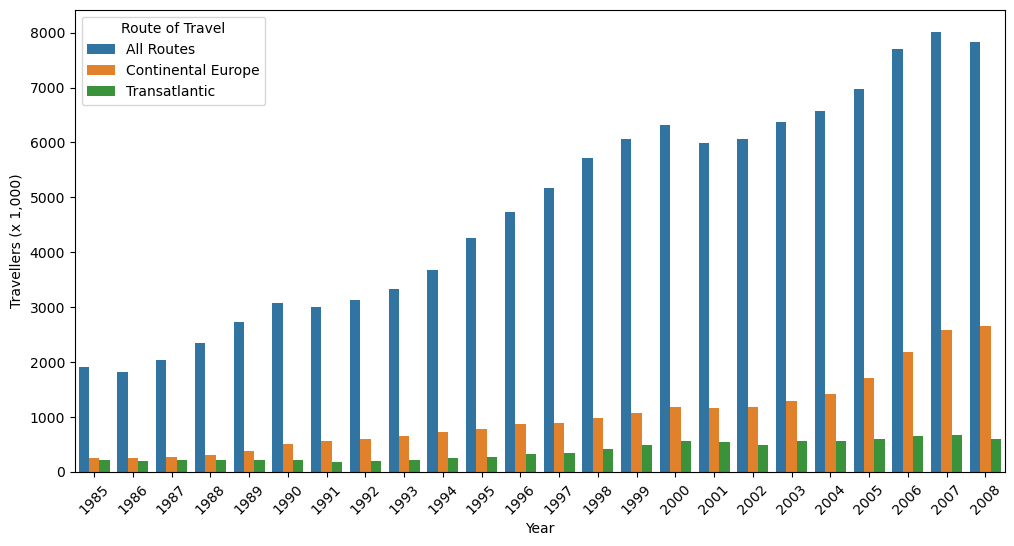

In [ ]:
# Assess demographics of tourists travelling to Ireland from different regions over time
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=in_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Create Seperate Dataframe of Outbound Travel from Ireland

In [ ]:
# Create new seperate dataframes for inbound Irish travel
outtourism_df = tourism_df[tourism_df['Inbound/Outbound'] == 'Visits Abroad by Irish Residents']
outtourism_df = outtourism_df.drop(columns=['Inbound/Outbound'])
#outtourism_df = outtourism_df.drop(outtourism_df[outtourism_df['Route of Travel'] == 'All Routes'].index)
#outtourism_df = outtourism_df.sum(outtourism_df[outtourism_df['Route of Travel'] == 'All Routes'].index)

In [ ]:
(outtourism_df.tail(5))

,Route of Travel,Year,Quarter,"Travellers (x 1,000)"
951,Transatlantic,2007,4,146
953,Transatlantic,2008,1,109
955,Transatlantic,2008,2,115
957,Transatlantic,2008,3,142
959,Transatlantic,2008,4,152


In [ ]:
outtourism_df.shape

(288, 4)

In [ ]:
outtourism_df.describe()

,Year,Quarter,"Travellers (x 1,000)"
count,288.000000,288.00000,288.000000
mean,1996.500000,2.50000,435.048611
std,6.934236,1.11998,509.967060
min,1985.000000,1.00000,5.000000
25%,1990.750000,1.75000,57.750000
50%,1996.500000,2.50000,216.000000
75%,2002.250000,3.25000,691.000000
max,2008.000000,4.00000,2428.000000


In [ ]:
# 5 categories for Routes of Travel with column 0 = Sum of columns 1-4
outtourism_df['Route of Travel'].value_counts() 

Route of Travel
All Routes            96
Continental Europe    96
Transatlantic         96
Name: count, dtype: int64

In [ ]:
# Create dataframe with values for each quarter of the year summed to give travel from Ireland per year by each route 
out_grouped = outtourism_df.groupby(['Year', 'Route of Travel'], as_index=False).sum().drop(columns=['Quarter'])
out_grouped

,Year,Route of Travel,"Travellers (x 1,000)"
0,1985,All Routes,1257
1,1985,Continental Europe,328
2,1985,Transatlantic,54
3,1986,All Routes,1375
4,1986,Continental Europe,350
5,1986,Transatlantic,71
6,1987,All Routes,1566
7,1987,Continental Europe,409
8,1987,Transatlantic,73
9,1988,All Routes,1747


<Figure size 1200x600 with 0 Axes>

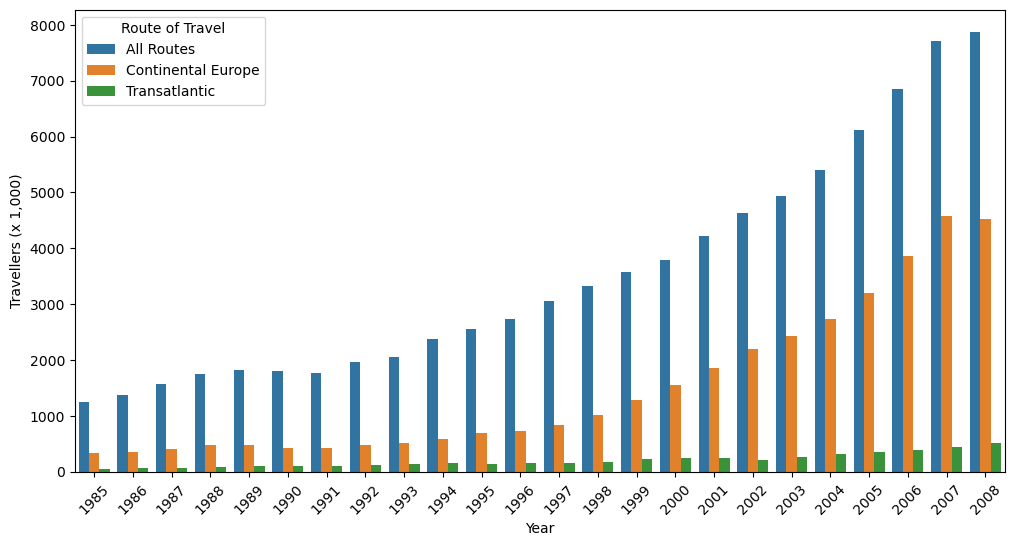

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions over time
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=out_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Travel to Ireland by Quarter
Q1: January – March, Q2: April – June, Q3: July – September, Q4: October – December

<Figure size 1200x600 with 0 Axes>

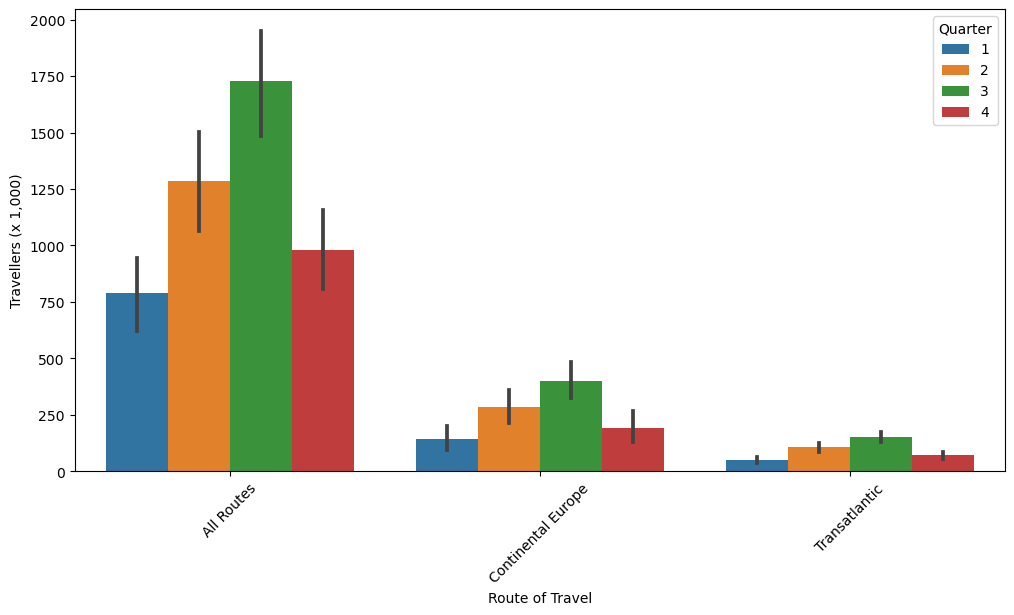

In [ ]:
# Assess demographics of tourists travelling to Ireland from different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=intourism_df, x="Route of Travel", y="Travellers (x 1,000)", hue='Quarter')
ax.tick_params(axis='x', labelrotation=45)

<Figure size 1200x600 with 0 Axes>

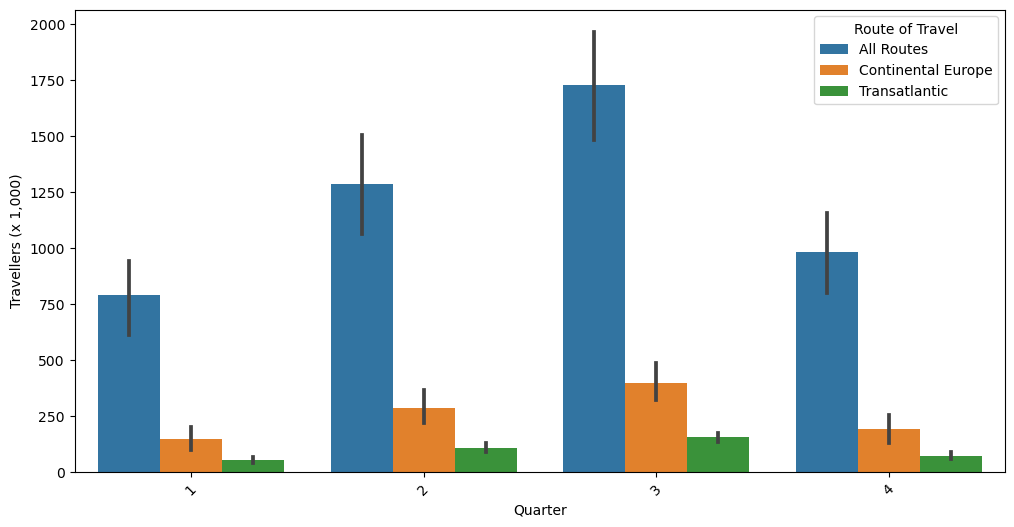

In [ ]:
# Assess demographics of tourists travelling to Ireland from different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=intourism_df, x="Quarter", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Travel from Ireland by Quarter

<Figure size 1200x600 with 0 Axes>

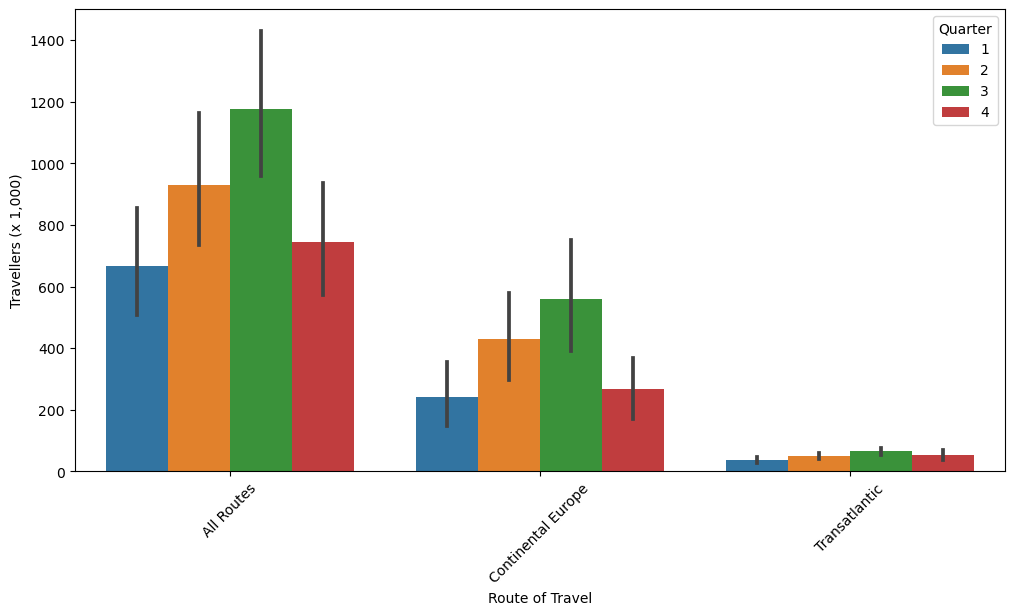

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=outtourism_df, x="Route of Travel", y="Travellers (x 1,000)", hue='Quarter')
ax.tick_params(axis='x', labelrotation=45)

<Figure size 1200x600 with 0 Axes>

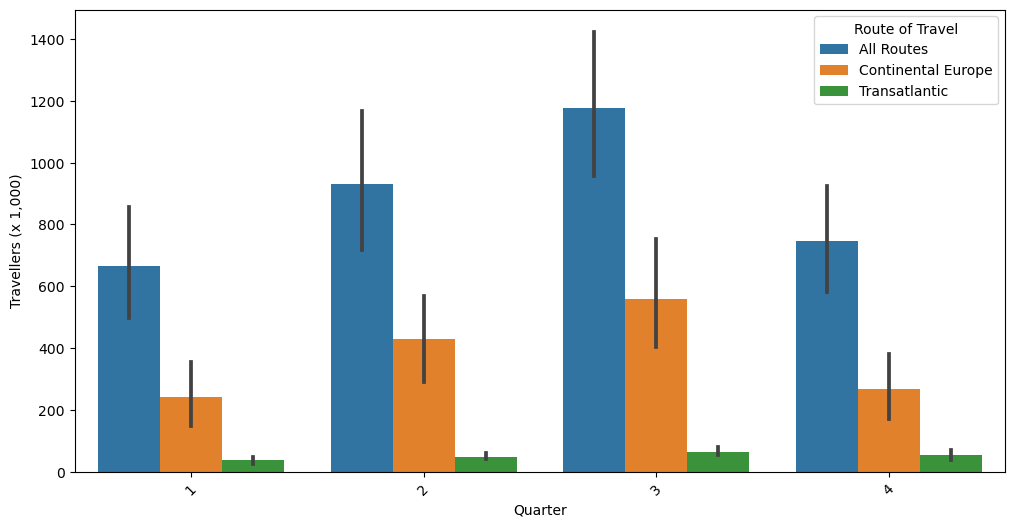

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=outtourism_df, x="Quarter", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Lineplot of Tourism out of Ireland

<Figure size 1200x600 with 0 Axes>

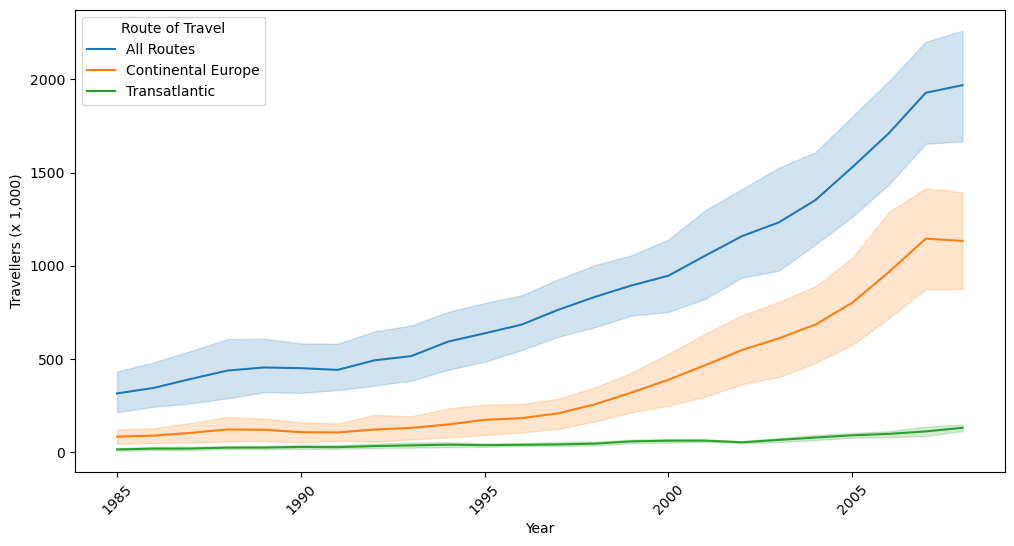

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter

plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=outtourism_df, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

<Figure size 1200x600 with 0 Axes>

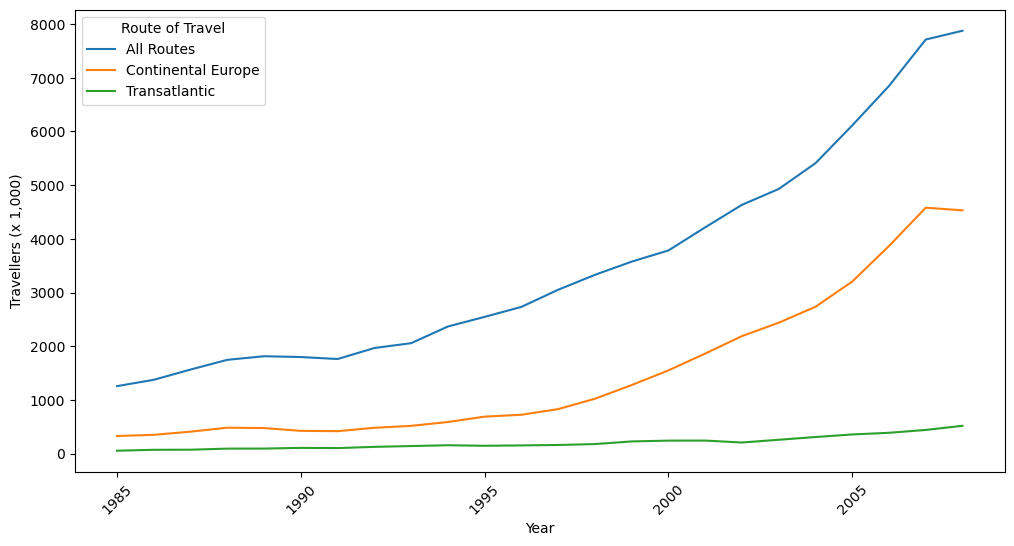

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=out_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

## Lineplot of Tourism into Ireland

<Figure size 1200x600 with 0 Axes>

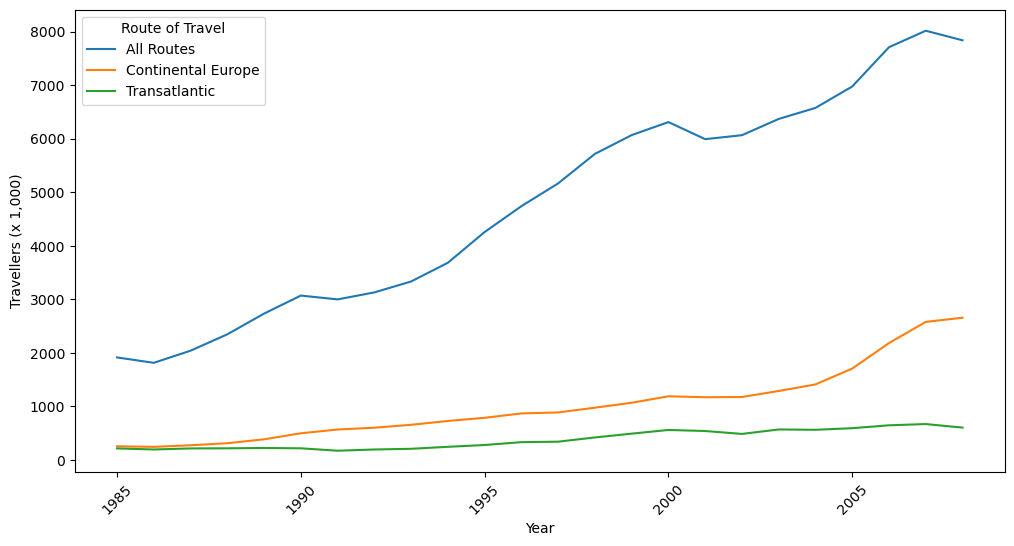

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=in_grouped, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)

<Figure size 1200x600 with 0 Axes>

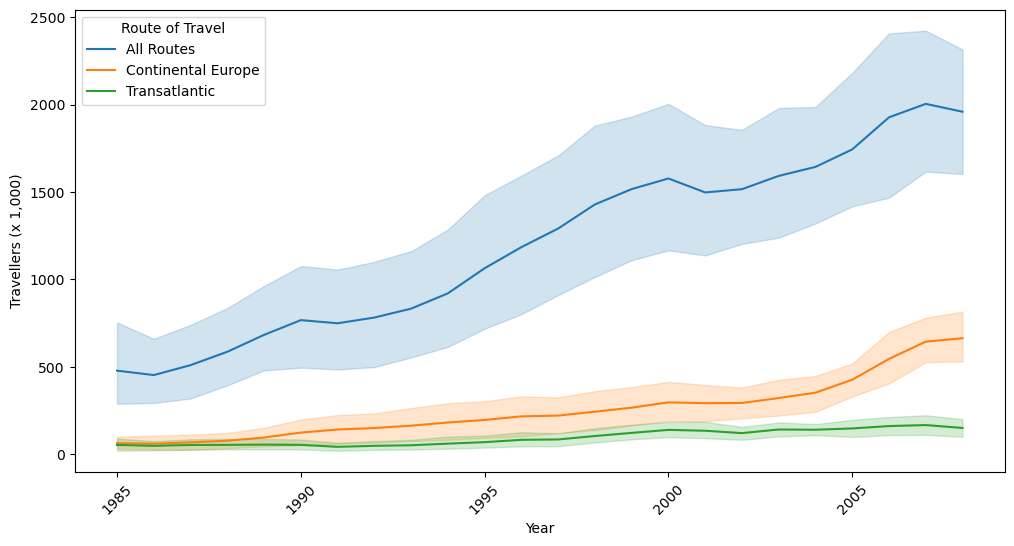

In [ ]:
# Assess demographics of tourists travelling from Ireland to different regions per Quarter
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=intourism_df, x="Year", y="Travellers (x 1,000)", hue='Route of Travel')
ax.tick_params(axis='x', labelrotation=45)